In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau

Populating the interactive namespace from numpy and matplotlib


/Users/jug/local/miniconda3/envs/BobSeg/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading and preparing data

```memchannel``` is the membrane channel only (needs to be taken out of loaded stack)<br>
```flowchannel``` is the myosin channel only<br>
```memchannel_smooth``` is the ```memchannel``` after gaussian smoothing<br>
(note: the less the better for the gradientimage)<br>
```segchannel``` should be used for segmentation if some of the cell boundary (membrane) is barely visible<br>

In [2]:
fn_membrane = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/MAX_20180417_mNG-NMY-2_mSc-PH_UNCOUPLED-01-03_Membrane.tif'
fn_myosin   = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/MAX_20180417_mNG-NMY-2_mSc-PH_UNCOUPLED-01-03_Myosin.tif'

memchannel = imread(fn_membrane)
flowchannel = imread(fn_myosin)

sigma = [0.,2,2]
memchannel_smooth = gaussian(memchannel,sigma)
flowchannel_smooth = gaussian(flowchannel,[0.,1,1])

segchannel = memchannel_smooth

T = len(memchannel)-1  # number of time-points (last one is not followed by myosin frames)
tempres_factor = int(len(flowchannel)/T)

if len(flowchannel)%T != 0:
    raise 'Tempres problem: please check imported data!'
else:
    print ('Tempres factor: %s'%tempres_factor)

print('Shape of membrane channel :', memchannel.shape)
print('Shape of flow channel:', flowchannel.shape)

Tempres factor: 5
('Shape of membrane channel :', (11, 444, 285))
('Shape of flow channel:', (50, 444, 285))


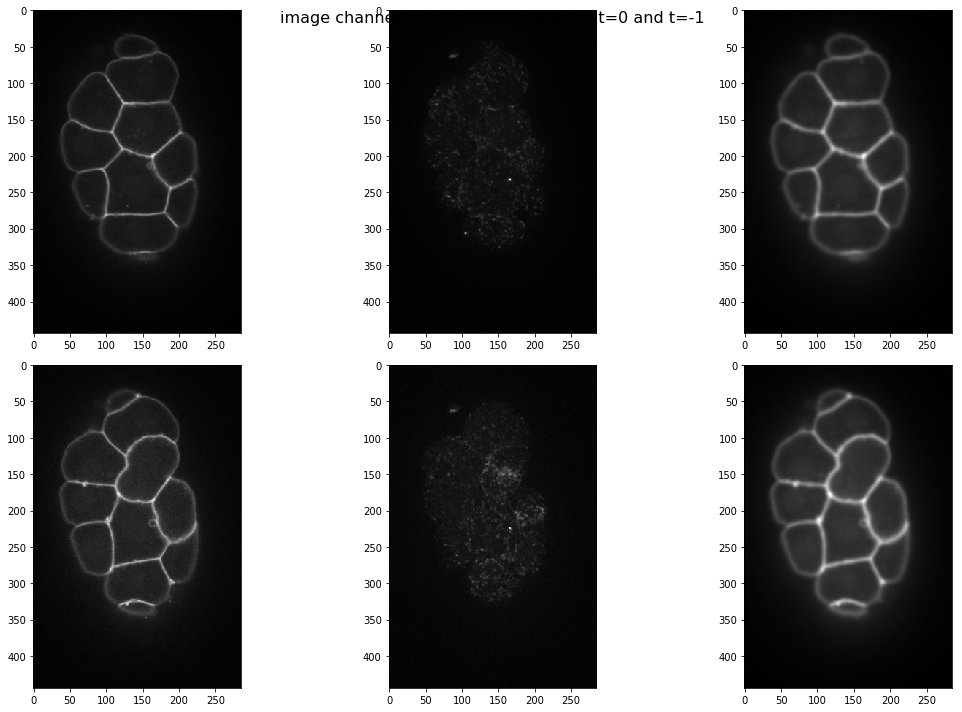

In [3]:
fig = bsu.sanity_check_loaded_data((16,10), memchannel, flowchannel, segchannel)

# Cell segmentation

In [4]:
# defining min and max radius for cell segmentation
max_rs = ((segchannel[0].shape[1] / 5),
          (segchannel[0].shape[1] / 5))

min_rs = (10,10)
print (min_rs, max_rs)

data = Data3d( segchannel, pixelsize=(1.,1.), silent=True )
data.set_seg_params(num_columns=72,K=50,max_delta_k=4)
objects = []

((10, 10), (57, 57))


In [5]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
data.add_object_at( cell_Ea, min_rs, max_rs, frame=0, seed=(140,240), segment_it=True )
moving_center_Ea = data.track(cell_Ea, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

In [6]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
data.add_object_at( cell_Ep, min_rs, max_rs, frame=0, seed=(145,300), segment_it=True )
moving_center_Ep = data.track(cell_Ep, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

In [7]:
surface_coords_Ea = data.segment2dt( cell_Ea, max_radial_delta=2 )

In [8]:
surface_coords_Ep = data.segment2dt( cell_Ep, max_radial_delta=2 )

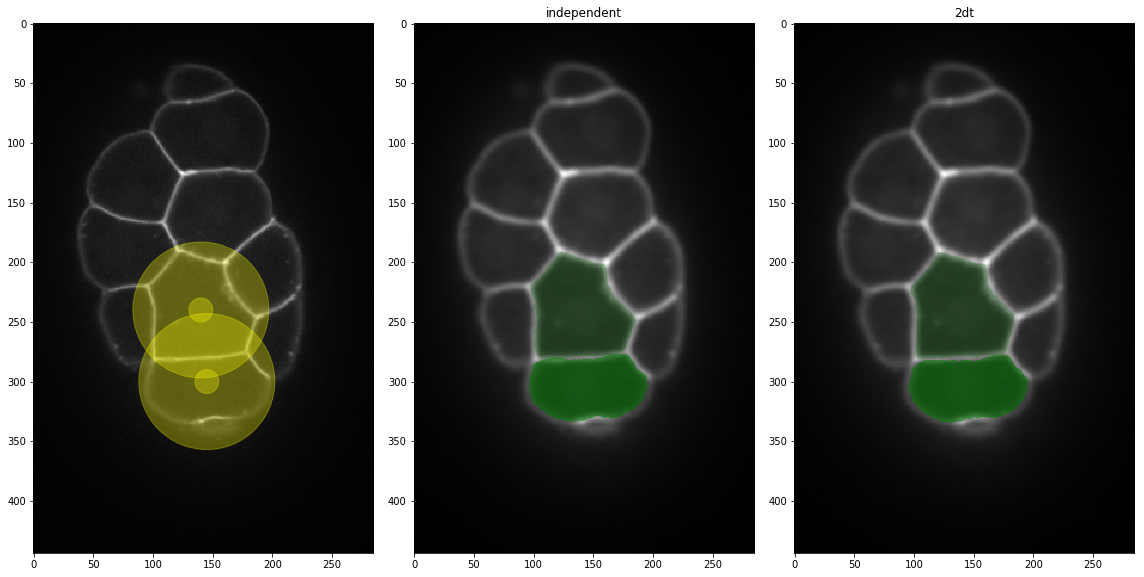

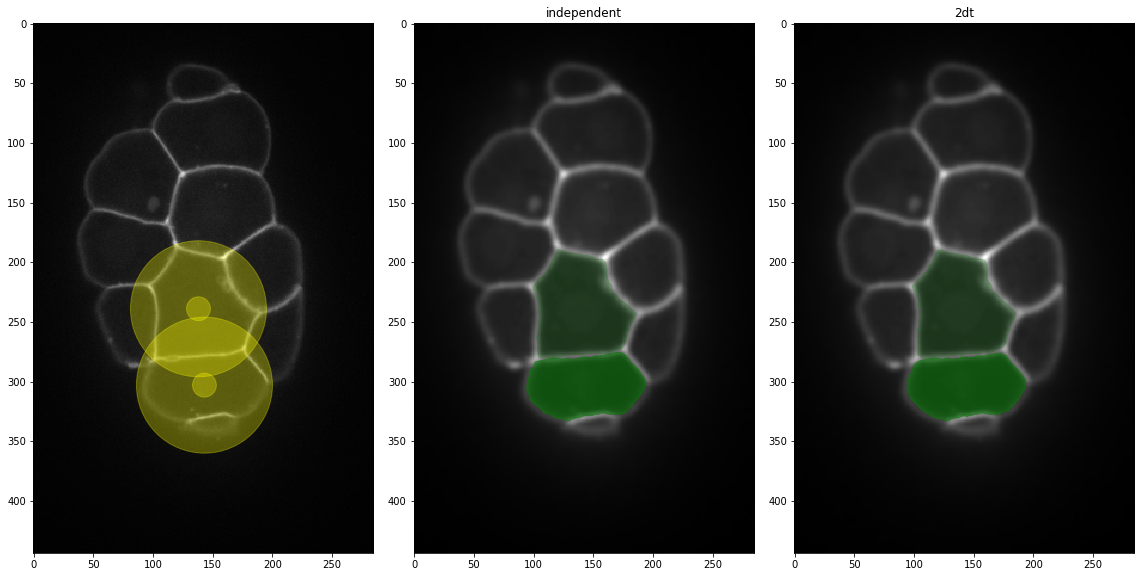

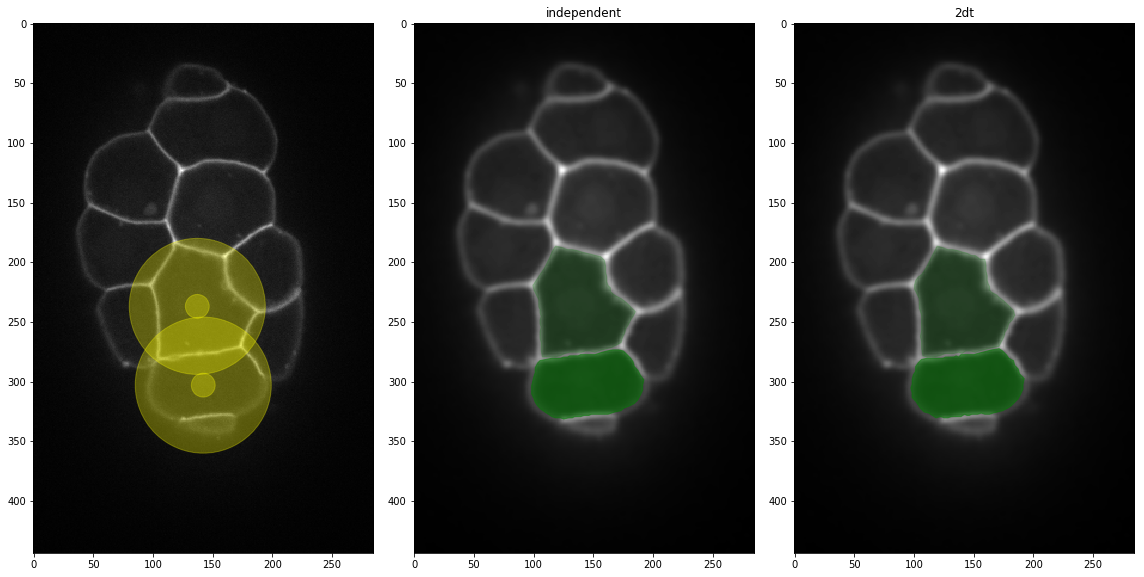

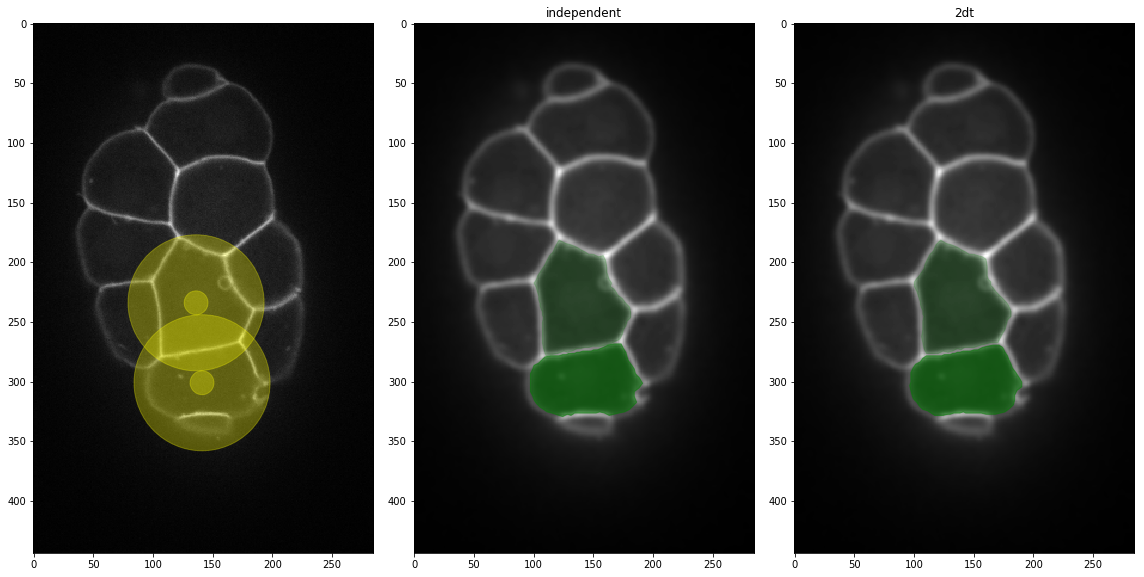

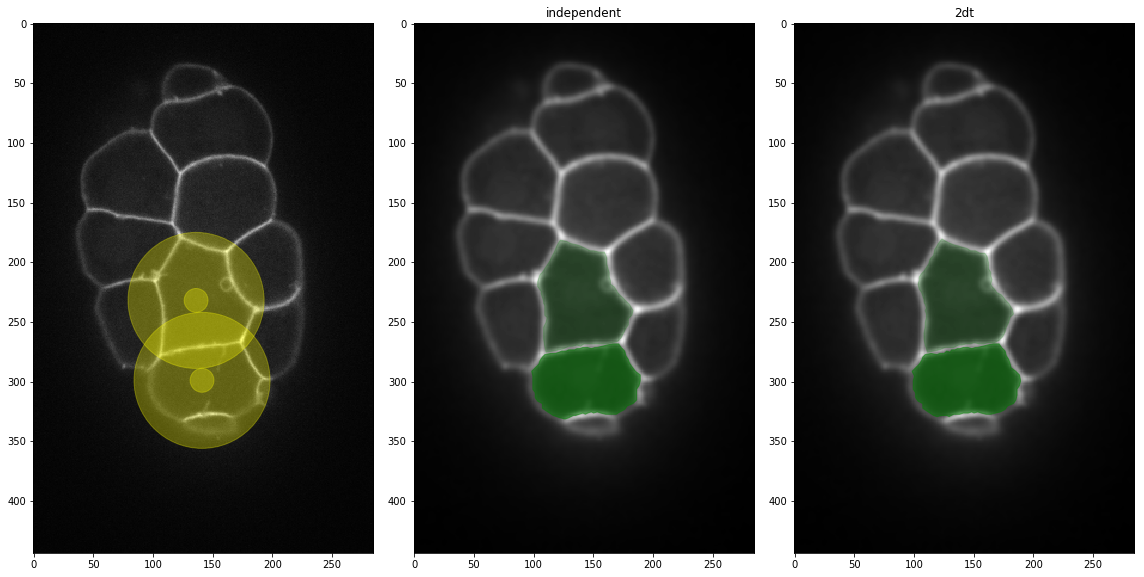

In [9]:
figs = bsu.sanity_check_segmentation((16, 10), data, memchannel, segchannel)

# Flow computation (taking higher frame-rate into account)

In [10]:
flows = bsu.compute_flow( flowchannel )
fast_flow_x, fast_flow_y = bsu.split_flow_components( flows )
flow_x = bsu.flow_merge_frames(fast_flow_x, tempres_factor)
flow_y = bsu.flow_merge_frames(fast_flow_y, tempres_factor)

.................................................. ...done!


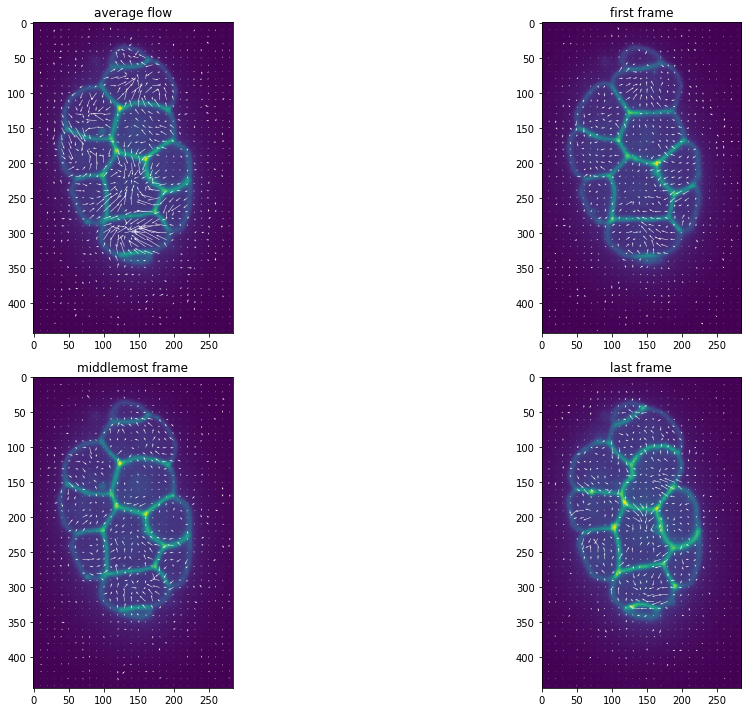

In [11]:
fig = bsu.sanity_check_flow((18, 10), segchannel, flow_x, flow_y)

# Flow data crunching...

In [12]:
annulus_outer_factor = .85
annulus_inner_factor = .6

In [13]:
membrane_polygones_per_object = []
annulus_outer_polygones_per_object = []
annulus_middle_polygones_per_object = []
annulus_inner_polygones_per_object = []
for obj in objects:
    membrane_polygones = []
    annulus_outer_polygones = []
    annulus_middle_polygones = []
    annulus_inner_polygones = []
    for t in range(T+1):
        membrane_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,1.0) )
        annulus_outer_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_outer_factor) )
        annulus_middle_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,(annulus_outer_factor+annulus_inner_factor)/2) )
        annulus_inner_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_inner_factor) )
    membrane_polygones_per_object.append(membrane_polygones)
    annulus_outer_polygones_per_object.append(annulus_outer_polygones)
    annulus_middle_polygones_per_object.append(annulus_middle_polygones)
    annulus_inner_polygones_per_object.append(annulus_inner_polygones)

In [14]:
def get_annulus_bresenham_lines(inner_polygone, outer_polygone):
    annulus_bresenham_lines = []
    for i in range(len(inner_polygone)):
        points = bham.bresenhamline( np.array([inner_polygone[i]]),np.array([outer_polygone[i]]) )
        annulus_bresenham_lines.append(points)
    return annulus_bresenham_lines

In [15]:
annulus_bresenham_lines_per_frame_per_object = []
for obj in objects:
    annulus_bresenham_lines_per_frame = []
    for t in range(T):
        annulus_bresenham_lines = get_annulus_bresenham_lines( annulus_inner_polygones_per_object[obj][t], annulus_outer_polygones_per_object[obj][t] )
        annulus_bresenham_lines_per_frame.append( annulus_bresenham_lines )
    annulus_bresenham_lines_per_frame_per_object.append( annulus_bresenham_lines_per_frame )

### compute membrane movement vectors

In [16]:
membrane_movement_vectors_per_frame_per_object = []
for obj in objects:
    membrane_movement_vectors_per_frame = []
    for t in range(T):
        membrane_movement_vectors = []
        poly_t1 = membrane_polygones_per_object[obj][t]
        poly_t2 = membrane_polygones_per_object[obj][t+1]
        for i in range(len(poly_t1)):
            p1 = [poly_t1[i][0] , poly_t1[i][1]]
            p2 = [poly_t2[i][0] , poly_t2[i][1]]
            membrane_movement_vectors.append( [p2[0]-p1[0] , p2[1]-p1[1]] )
        membrane_movement_vectors_per_frame.append( membrane_movement_vectors )
    membrane_movement_vectors_per_frame_per_object.append( membrane_movement_vectors_per_frame )

### compute averaged flow vectors

In [18]:
annulus_avg_flow_vectors_per_frame_per_object = []
for obj in objects:
    annulus_avg_flow_vectors_per_frame = []
    for t in range(T):
        annulus_avg_flow_vectors = []
        lines = annulus_bresenham_lines_per_frame_per_object[obj][t]
        for l, line in enumerate(lines):
            sum_x = 0.0
            sum_y = 0.0
            for point in line:
                sum_x += flow_x[t,point[1],point[0]]
                sum_y += flow_y[t,point[1],point[0]]
            avg_x = sum_x / len(line)
            avg_y = sum_y / len(line)
            annulus_avg_flow_vectors.append([avg_x,avg_y])
        annulus_avg_flow_vectors_per_frame.append(annulus_avg_flow_vectors)
    annulus_avg_flow_vectors_per_frame_per_object.append( annulus_avg_flow_vectors_per_frame )

### compute projected vector lengths

In [19]:
column_vectors = data.netsurfs[0][0].col_vectors # they are normalized to length 1

In [20]:
projected_avg_flows_per_frame_per_object = []
projected_mem_vecs_per_frame_per_object = []
for obj in objects:
    projected_avg_flows_per_frame = []
    projected_mem_vecs_per_frame = []
    for t in range(T):
        projected_avg_flows = []
        projected_mem_vecs = []
        for i in range(len(column_vectors)):
            projected_avg_flows.append( bsu.get_projected_length(annulus_avg_flow_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
            projected_mem_vecs.append( bsu.get_projected_length(membrane_movement_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
        projected_avg_flows_per_frame.append( projected_avg_flows )
        projected_mem_vecs_per_frame.append( projected_mem_vecs )
    projected_avg_flows_per_frame_per_object.append( projected_avg_flows_per_frame )
    projected_mem_vecs_per_frame_per_object.append( projected_mem_vecs_per_frame )

### compute frame averages and correlations for lineplots

In [21]:
avg_membrane_contraction_per_frame_per_object = []
avg_center_flow_per_frame_per_object = []
correlation_per_frame_per_object = []
slippage_per_frame_per_object = []
for obj in objects:
    avg_membrane_contraction_per_frame = []
    avg_center_flow_per_frame = []
    correlation_per_frame = []
    slippage_per_frame = []
    for t in range(T):
        memveclengths=projected_mem_vecs_per_frame_per_object[obj][t]
        flowveclengths=projected_avg_flows_per_frame_per_object[obj][t]
        
        avg_membrane_contraction_per_frame.append( np.mean(memveclengths) )
        avg_center_flow_per_frame.append( np.mean( flowveclengths) )
        correlation_per_frame.append( pearsonr(memveclengths, flowveclengths)[0] )
        
        slippage_per_frame.append( np.mean(flowveclengths) - np.mean(memveclengths) )
                
    avg_membrane_contraction_per_frame_per_object.append( avg_membrane_contraction_per_frame )
    avg_center_flow_per_frame_per_object.append( avg_center_flow_per_frame )
    correlation_per_frame_per_object.append( correlation_per_frame )
    slippage_per_frame_per_object.append( slippage_per_frame )

# Plotting crunched flow data

In [24]:
figs = bsu.plot_big_analysis((12,10),
                  objects,
                  data,
                  segchannel,
                  correlation_per_frame_per_object, 
                  slippage_per_frame_per_object, 
                  avg_membrane_contraction_per_frame_per_object, 
                  avg_center_flow_per_frame_per_object,
                  membrane_polygones_per_object,
                  membrane_movement_vectors_per_frame_per_object,
                  projected_mem_vecs_per_frame_per_object,
                  projected_avg_flows_per_frame_per_object,
                  annulus_inner_polygones_per_object,
                  annulus_middle_polygones_per_object,
                  annulus_outer_polygones_per_object,
                  annulus_avg_flow_vectors_per_frame_per_object,
                  show_projected=False)

KeyError: 0